# Autoencoders for Learning Image Embeddings

This notebook demonstrates how good (or poor) are the image representations learned by the encoder of an autoencoder when used as feature extractor in a downstream image classification task

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import os
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.data import Dataset
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import layers as L
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model

## Data Preparation

In [2]:
IMG_SIZE = (96, 96, 3)
BATCH_SIZE = 32
EPOCHS = 20

images_train = glob("../input/fruits/fruits-360_dataset/fruits-360/Training/*/*")
images_valid = glob("../input/fruits/fruits-360_dataset/fruits-360/Test/*/*")
targets = os.listdir("../input/fruits/fruits-360_dataset/fruits-360/Training/")

In [3]:
def load_images_clf(imagePath):
    image = tf.io.read_file(imagePath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.resize(image, IMG_SIZE[:-1])    
    label = tf.strings.split(imagePath, os.path.sep)[-2]
    
    oneHot = label == targets
    encodedLabel = tf.argmax(oneHot)

    return (image, encodedLabel)

def load_images_enc(imagePath):
    image = tf.io.read_file(imagePath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.resize(image, IMG_SIZE[:-1])

    return (image, image)

In [4]:
def get_callbacks(log_path):
    return [
        CSVLogger(log_path), 
        ReduceLROnPlateau(patience=3, verbose=1, min_delta=1e-3),
        EarlyStopping(min_delta=1e-3, patience=7, verbose=1, restore_best_weights=True)
    ]

# Pretraining Autoencoder

In [5]:
inputs = keras.Input(shape=IMG_SIZE, name='encoder_inputs')
x = L.Conv2D(32, 3, padding='same', activation='relu', name='encoder_conv_1_1')(inputs)
x = L.Dropout(0.2, name="encoder_drop_1")(x)
x = L.Conv2D(32, 3, padding='same', activation='relu', name='encoder_conv_1_2')(x)
x = L.MaxPool2D(padding='same', name='encoder_pool_1')(x)
x = L.Conv2D(64, 3, padding='same', activation='relu', name='encoder_conv_2_1')(x)
x = L.Dropout(0.2, name="encoder_drop_2")(x)
x = L.Conv2D(64, 3, padding='same', activation='relu', name='encoder_conv_2_2')(x)
encoded = L.MaxPool2D(padding='same', name='encoder_pool_2')(x)
x = L.Conv2D(64, 3, padding='same', activation='relu', name='decoder_conv_1_1')(encoded)
x = L.Dropout(0.2, name="decoder_drop_1")(x)
x = L.Conv2D(64, 3, padding='same', activation='relu', name='decoder_conv_1_2')(x)
x = L.UpSampling2D(name='decoder_upsample_1')(x)
x = L.Conv2D(32, 3, padding='same', activation='relu', name='decoder_conv_2_1')(x)
x = L.Dropout(0.2, name="decoder_drop_2")(x)
x = L.Conv2D(32, 3, padding='same', activation='relu', name='decoder_conv_2_2')(x)
x = L.UpSampling2D(name='decoder_upsample_2')(x)
outputs = L.Conv2D(3, 1, padding='same', activation='sigmoid', name='decoder_output')(x)

autoencoder = Model(inputs=inputs, outputs=outputs, name='autoencoder')
autoencoder.compile(optimizer=Adam(1e-3), loss='binary_crossentropy')
autoencoder.summary()

2022-08-03 05:38:11.034478: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 05:38:11.124098: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 05:38:11.125017: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 05:38:11.126524: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inputs (InputLayer)  [(None, 96, 96, 3)]       0         
_________________________________________________________________
encoder_conv_1_1 (Conv2D)    (None, 96, 96, 32)        896       
_________________________________________________________________
encoder_drop_1 (Dropout)     (None, 96, 96, 32)        0         
_________________________________________________________________
encoder_conv_1_2 (Conv2D)    (None, 96, 96, 32)        9248      
_________________________________________________________________
encoder_pool_1 (MaxPooling2D (None, 48, 48, 32)        0         
_________________________________________________________________
encoder_conv_2_1 (Conv2D)    (None, 48, 48, 64)        18496     
_________________________________________________________________
encoder_drop_2 (Dropout)     (None, 48, 48, 64)        

ead from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-03 05:38:13.236132: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15403 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [6]:
enc_train = (
    Dataset.from_tensor_slices(images_train)
    .shuffle(1024)
    .map(load_images_enc, num_parallel_calls=-1)
    .cache()
    .batch(BATCH_SIZE)
)
enc_valid = (
    Dataset.from_tensor_slices(images_valid)
    .shuffle(1024)
    .map(load_images_enc, num_parallel_calls=-1)
    .cache()
    .batch(BATCH_SIZE)
)

2022-08-03 05:38:14.273201: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-08-03 05:38:15.833600: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2116/2116 [==============================] - 243s 111ms/step - loss: 0.3535 - val_loss: 0.3583
Epoch 2/20
2116/2116 [==============================] - 51s 24ms/step - loss: 0.3480 - val_loss: 0.3855
Epoch 3/20
2116/2116 [==============================] - 51s 24ms/step - loss: 0.3478 - val_loss: 0.3749
Epoch 4/20
2116/2116 [==============================] - 51s 24ms/step - loss: 0.3483 - val_loss: 0.3814

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/20
2116/2116 [==============================] - 51s 24ms/step - loss: 0.3470 - val_loss: 0.3859
Epoch 6/20
2116/2116 [==============================] - 51s 24ms/step - loss: 0.3469 - val_loss: 0.3904
Epoch 7/20
2116/2116 [==============================] - 51s 24ms/step - loss: 0.3467 - val_loss: 0.3971

Epoch 00007: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 8/20
2116/2116 [==============================] - 51s 24ms/step - loss: 0.3467 - val_loss: 0.4014
Restoring mod

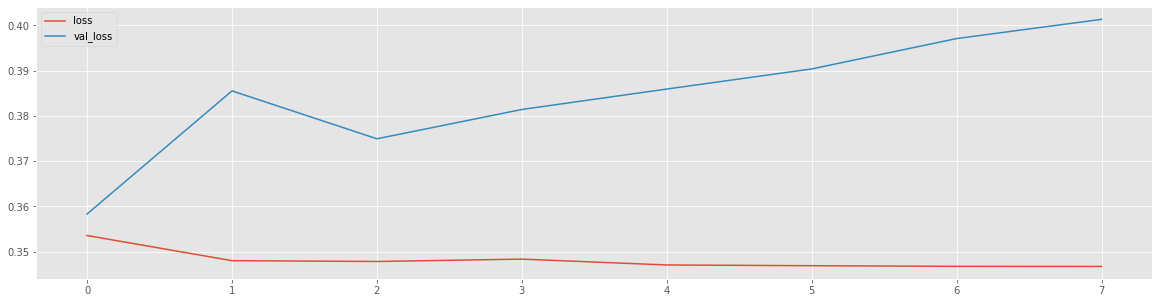

In [7]:
history_ae_u = autoencoder.fit(
    enc_train, validation_data=enc_valid,epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, 
    callbacks=get_callbacks('autoencoder_pretraining.csv')
)
encoder_base = keras.Model(inputs, encoded, name='encoder_base')
encoder_base.save('encoder_base.h5')

hist_df = pd.DataFrame(history_ae_u.history)
fig, ax = plt.subplots(figsize=(20, 5))
hist_df.iloc[:, :-1].plot(ax=ax);

In [8]:
del enc_train, enc_valid, autoencoder, encoder_base

# Feature Extraction from Encoder

In [9]:
clf_train = (
    Dataset.from_tensor_slices(images_train)
    .shuffle(1024)
    .map(load_images_clf, num_parallel_calls=-1)
    .cache()
    .batch(BATCH_SIZE)
)
clf_valid = (
    Dataset.from_tensor_slices(images_valid)
    .shuffle(1024)
    .map(load_images_clf, num_parallel_calls=-1)
    .cache()
    .batch(BATCH_SIZE)
)

Epoch 1/20
2116/2116 [==============================] - 177s 83ms/step - loss: 1.6738 - accuracy: 0.6826 - val_loss: 3.8782 - val_accuracy: 0.1046
Epoch 2/20
2116/2116 [==============================] - 17s 8ms/step - loss: 0.4687 - accuracy: 0.8834 - val_loss: 2.9795 - val_accuracy: 0.2015
Epoch 3/20
2116/2116 [==============================] - 16s 8ms/step - loss: 0.1860 - accuracy: 0.9459 - val_loss: 2.7221 - val_accuracy: 0.2799
Epoch 4/20
2116/2116 [==============================] - 17s 8ms/step - loss: 0.1028 - accuracy: 0.9700 - val_loss: 2.4853 - val_accuracy: 0.3389
Epoch 5/20
2116/2116 [==============================] - 17s 8ms/step - loss: 0.0680 - accuracy: 0.9799 - val_loss: 2.2717 - val_accuracy: 0.4036
Epoch 6/20
2116/2116 [==============================] - 16s 8ms/step - loss: 0.0500 - accuracy: 0.9857 - val_loss: 2.1024 - val_accuracy: 0.4480
Epoch 7/20
2116/2116 [==============================] - 17s 8ms/step - loss: 0.0378 - accuracy: 0.9894 - val_loss: 1.9569 - val_

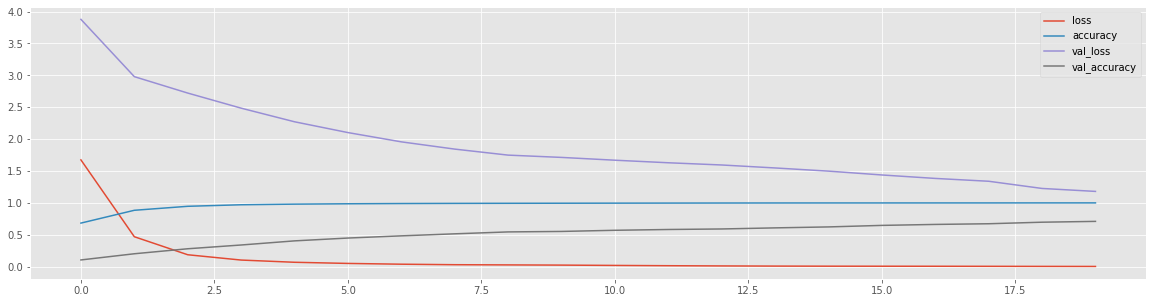

In [10]:
encoder_base = load_model('encoder_base.h5')
encoder_base.trainable = False

encoder = Sequential([
    encoder_base,
    L.Flatten(name='encoder_flatten'),
    L.Dense(len(targets), activation='softmax', name='encoder_classification_head')
])
encoder.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_ae_d = encoder.fit(
    clf_train, validation_data=clf_valid, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True,
    callbacks=get_callbacks('autoencoder_finetuning.csv')
)
encoder.save('encoder_finetuned.h5')

loss, accuracy = encoder.evaluate(clf_valid)
print(f"\n\nAccuracy of Autoencoder Finetuned Classifier: {accuracy}")

hist_df = pd.DataFrame(history_ae_d.history)
fig, ax = plt.subplots(figsize=(20, 5))
hist_df.iloc[:, :-1].plot(ax=ax);